<h3>Multilayer Perceptron Training for F-MNIST Classification</h3>

![Image of F-MNIST](https://www.researchgate.net/profile/Saeed-Reza-Kheradpisheh/publication/342801790/figure/fig2/AS:911232181735425@1594266090934/Sample-images-from-Fashion-MNIST-dataset.jpg)
>Image source: [Kheradpisheh et al. (2020)](https://www.researchgate.net/publication/342801790_BS4NN_Binarized_Spiking_Neural_Networks_with_Temporal_Coding_and_Learning)

- In a similar fashion to the MNIST database (pun intended), Fashion-MNIST is a collection of monochrome images, only this time consisting exclusively of basic clothing items such as T-shirts, dresses, etc. It consists of a training set of 60,000 examples and a test set of 10,000 examples, each of which is a 28x28 grayscale image.

<h3>The goal of this project</h3>
        
- In this IPython notebook we will use PyTorch, a deep learning library to build a multilayer perceptron (MLP) which will allow us to accurately classify the hand written digits contained within the MNIST dataset. This work was inspired by [Xiao et al. (2017)](https://arxiv.org/pdf/1708.07747.pdf) and Udacity's "Intro to Deep Learning with PyTorch".

<h4>Step 1 - Import Modules and Datasets</h4>

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



<AxesSubplot:>

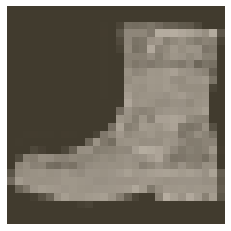

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define a transformation to normalize the dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Creating a function to visualize the dataset
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

image, label = next(iter(trainloader))
imshow(image[0,:])

<h4>Step 2 - Define the MLP Architecture </h4>

In [2]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with a 0.2 drop probability 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1)    
        # Set the activation functions
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
    
        return x
    
model = Classifier()
criterion = nn.NLLLoss(reduction ='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

<h4>Step 3 - Training and Evaluating the Model </h4>

In [3]:
epochs = 30
train_losses, test_losses = [], []


for e in range(epochs):
    tot_train_loss = 0 
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tot_train_loss += loss.item()
    else:
        tot_test_loss = 0
        test_correct = 0
        # Turn off gradients for validation to save memory and speed up computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()
                
        model.train()
        
        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)
        
        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss {:.3f}.. ".format(train_loss),
              "Test Loss {:.3f}.. ".format(test_loss),
              "Test Accuracy {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/30..  Training Loss 0.607..  Test Loss 0.515..  Test Accuracy 0.810
Epoch: 2/30..  Training Loss 0.481..  Test Loss 0.431..  Test Accuracy 0.841
Epoch: 3/30..  Training Loss 0.451..  Test Loss 0.426..  Test Accuracy 0.846
Epoch: 4/30..  Training Loss 0.432..  Test Loss 0.398..  Test Accuracy 0.858
Epoch: 5/30..  Training Loss 0.419..  Test Loss 0.396..  Test Accuracy 0.860
Epoch: 6/30..  Training Loss 0.413..  Test Loss 0.385..  Test Accuracy 0.862
Epoch: 7/30..  Training Loss 0.401..  Test Loss 0.404..  Test Accuracy 0.858
Epoch: 8/30..  Training Loss 0.403..  Test Loss 0.415..  Test Accuracy 0.851
Epoch: 9/30..  Training Loss 0.392..  Test Loss 0.375..  Test Accuracy 0.868
Epoch: 10/30..  Training Loss 0.382..  Test Loss 0.416..  Test Accuracy 0.854
Epoch: 11/30..  Training Loss 0.386..  Test Loss 0.378..  Test Accuracy 0.871
Epoch: 12/30..  Training Loss 0.383..  Test Loss 0.399..  Test Accuracy 0.861
Epoch: 13/30..  Training Loss 0.379..  Test Loss 0.389..  Test Accuracy 0

#### <h4>Step 4.1 - Visualizing the training and validation loss </h4>

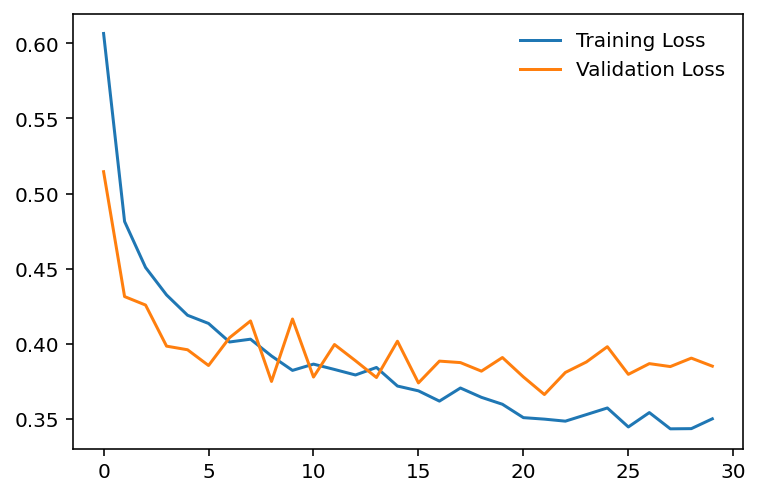

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)

<h4>Step 4.2 - Examining the accuracy of the mode on the test set </h4>

In [5]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Identifying the accuracy of the model on the test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 85 %
Accuracy for class: T-shirt/top is 84.3 %
Accuracy for class: Trouser is 96.3 %
Accuracy for class: Pullover is 76.7 %
Accuracy for class: Dress is 86.5 %
Accuracy for class: Coat  is 81.8 %
Accuracy for class: Sandal is 91.8 %
Accuracy for class: Shirt is 61.5 %
Accuracy for class: Sneaker is 94.7 %
Accuracy for class: Bag   is 93.8 %
Accuracy for class: Ankle Boot is 92.9 %


<h4>Step 4.3 - Calculate the classification probability of a random image </h4>

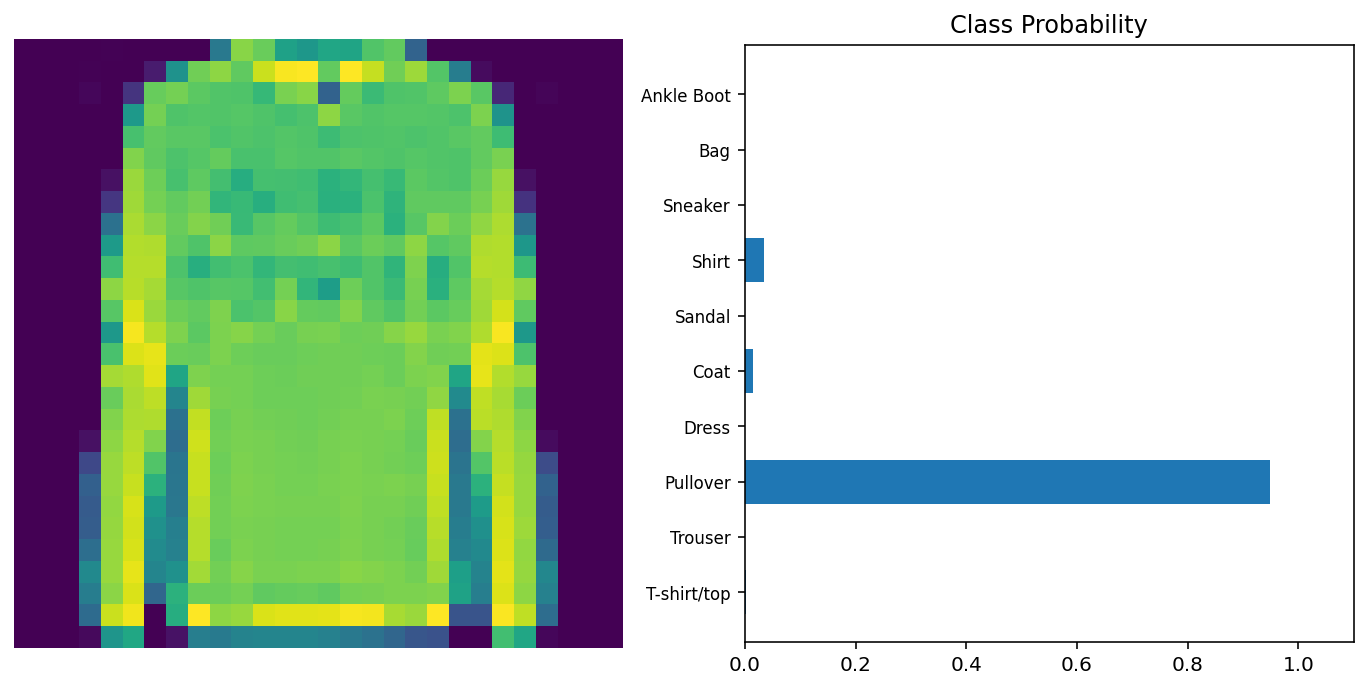

In [6]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
# Plot the image and probabilities through a custom function

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(12,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
view_classify(img.view(1, 28, 28), ps, version='Fashion')

<h4> Final remarks</h4>

The MLP model presented here can achieve an accuracy of 86% on an unseen test set. Though this is significantly better than random guessing, please note that tuning the hyperparameters of the model further or upgrading the model into a CNN can lead to further accuracy improvements.